# 002 Testing Env 1

In [1]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'


import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

from resources import build_agent, TrainingSession
import pandas as pd
import gc


2025-06-01 01:52:18.341852: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 01:52:18.347883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 01:52:18.451750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 01:52:20.727563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Historical Environments
# 1 - Observation: walls + distance, 3 rewards
# 2 - Observation: walls + r + theta, 4 rewards
# 3 - Observation: walls + r + theta + movement history, 4 rewards
hist_env = 1


# Hiperparameters
num_iterations = 10_000 

initial_collect_steps = 64  
collect_steps_per_iteration = 1 
replay_buffer_max_length = 100  

batch_size = 64  
learning_rate = 1e-3  
log_interval = 100  

num_eval_episodes = 10  
eval_interval = 100  

# Agent fully connected layer params 
fc_layer_params = (200,) 
without_wall_training = False
early_stop = None

# File's name
description = "101"

# Size of the maze
maze_size = 10

# Reward combination
combination = 2 
run = 1

rewards = []
rewards.append({
    'destroyed': -10.,
    'stuck': - 6.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})


sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

# Importing custom environment
env_name = f'maze-v0-{hist_env}'
env = suite_gym.load(env_name)

# Testing
env.reset()

train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)



Historical Environment updated:  1
Historical Environment updated:  1


## Training

In [3]:
# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env, hist_env)
agent.initialize()




In [4]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(5,), dtype=dtype('float32'), name='observation', minimum=[0. 0. 0. 0. 0.], maximum=[ 1.  1.  1.  1. 20.])


In [5]:
print('Observation Spec:')
print(train_py_env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(5,), dtype=dtype('float32'), name='observation', minimum=[0. 0. 0. 0. 0.], maximum=[ 1.  1.  1.  1. 20.])


In [6]:
train_py_env.print_environment()

Rewards: {'destroyed': -6.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Size: 3
Mode: 0
Hist env: 1


In [7]:
time_step = train_env.reset()

In [8]:
time_step

TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 1., 1., 2.]], dtype=float32)>})

In [9]:

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=without_wall_training, early_stop=early_stop)


# LOGGING
df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})
df_log.to_csv(f"logs/06-hist-env/{description}-checkpoint_0-run_{run}.csv", index=None, header=True)

Historical Environment updated:  1
Historical Environment updated:  1
Rewards Updated: {'destroyed': -10.0, 'stuck': -15.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -15.0, 'reached': 10.0, 'standard': -1.0}
Mode set: 0
Mode set: 0
Maze site set: 10x10
Maze site set: 10x10
Historical Environment updated:  1
Historical Environment updated:  1
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -10.0, 'stuck': -15.0, 'reached': 10.0, 'standard': -1.0}
Size: 10
Mode: 0
Hist env: 1
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000
step = 2000
step = 3000
step = 4000
step = 5000
step = 6000
step = 7000
step = 8000
step = 9000
step = 10000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=()

## Generate the video

In [ ]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(without_wall_training)
train_py_env.set_size(maze_size)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent-{description}", train_env, train_py_env)

Mode set: False
Maze site set: 10x10


In [1]:
from resources import plot_moving_avg

2025-06-01 02:28:52.888919: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 02:28:53.142424: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 02:28:54.161682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 02:28:56.151498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: module 'keras._tf_keras.keras' has no attribute '__internal__'

In [ ]:
from resources import plot_all_metrics

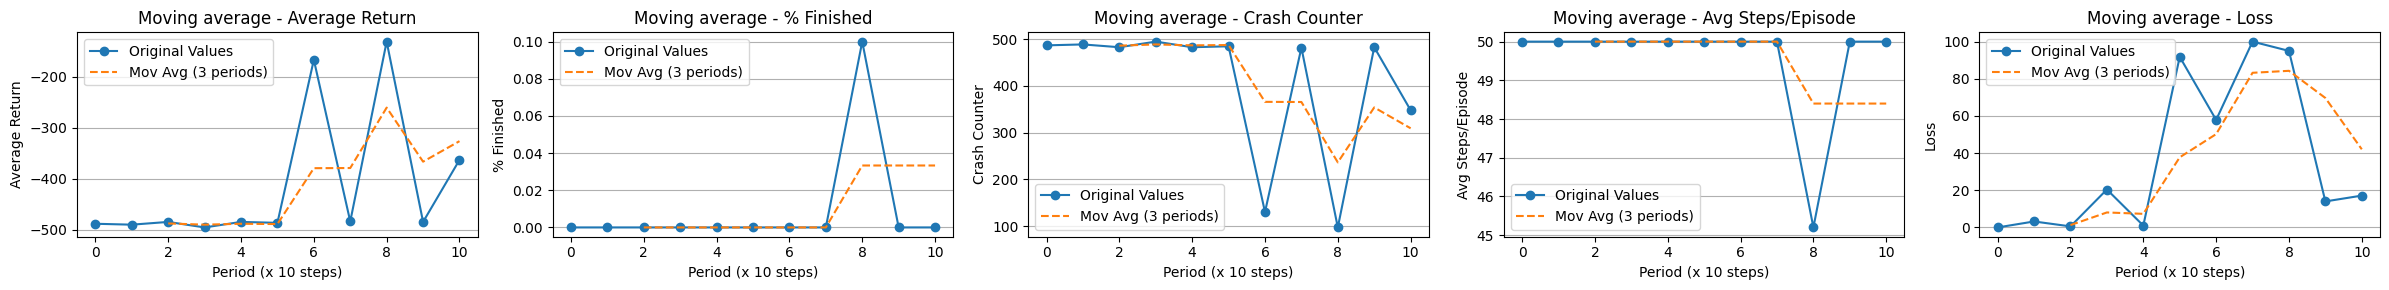

In [ ]:
plot_all_metrics(df_log, period=3, hist_env=hist_env)